In [1]:
from datetime import datetime
import pandas as pd
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from dateutil.parser import parse

ProgressBar().register()

In [2]:
FHV = dd.read_csv('May_to_Aug_FHV_Data.csv')
FHV = FHV.drop(columns='Unnamed: 0').reset_index(drop=True)

In [3]:
FHV.PUTime = dd.to_datetime(FHV.PUTime)
FHV.DOTime = dd.to_datetime(FHV.DOTime)

In [4]:
FHV['Hour'] = FHV.PUTime.dt.hour
FHV['DOW'] = FHV.PUTime.dt.dayofweek

In [5]:
FHV['overnight'] = 0

In [6]:
FHV['overnight'] = FHV['overnight'].mask(((FHV['Hour'] > 0) & (FHV['Hour'] < 6)), 1)

In [7]:
FHV = FHV[(FHV['Duration'] >= 5) & (FHV['Duration'] <= 150)].compute() # Only keep rides between 5 minutes and 2.5 hours

[########################################] | 100% Completed |  1min 23.4s


In [15]:
taxi_zones[taxi_zones['zone'] == 'JFK Airport']

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
131,132,0.245479,0.002038,JFK Airport,132,Queens,"MULTIPOLYGON (((1032791.001 181085.006, 103283..."


In [8]:
FHV = FHV[~((FHV['PULocationID'] == 1) | (FHV['DOLocationID'] == 1))] # Drop all trips to and from Newark
FHV = FHV[~((FHV['PULocationID'] == 132) | (FHV['DOLocationID'] == 132))] # Drop all trips to and from JF

In [17]:
FHV.head()

,Company,PULocationID,DOLocationID,PUTime,DOTime,Duration,Hour,DOW,overnight
0,Uber,151,244,2020-05-06 00:01:26,2020-05-06 00:10:14,8.800000,0,2,0
1,Uber,74,32,2020-05-06 00:43:42,2020-05-06 00:59:27,15.750000,0,2,0
2,Via,35,177,2020-05-06 00:27:39,2020-05-06 00:35:04,7.416667,0,2,0
3,Via,188,61,2020-05-06 00:52:35,2020-05-06 00:58:13,5.633333,0,2,0
4,Uber,225,35,2020-05-06 00:19:59,2020-05-06 00:28:43,8.733333,0,2,0


In [9]:
FHV[FHV['overnight']==1]['Duration'].mean()

15.039382406779183

Text(0.5, 1.0, 'Total Log Distribution of Ride Duration')

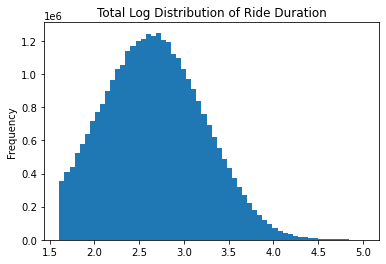

In [20]:
np.log(FHV['Duration']).plot.hist(bins=60)
plt.title('Total Log Distribution of Ride Duration')

Text(0.5, 1.0, 'Log Distribution of Overnight Ride Duration')

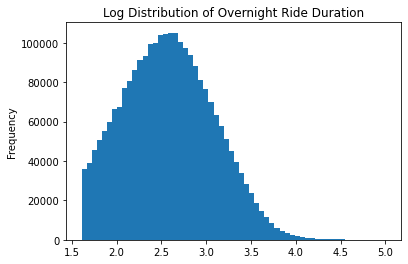

In [21]:
np.log(FHV[(FHV['overnight'] == 1)]['Duration']).plot.hist(bins=60)
plt.title('Log Distribution of Overnight Ride Duration')

In [22]:
from scipy import stats
stats.ttest_ind((FHV[(FHV['overnight'] == 1)]['Duration']), FHV['Duration'])

Ttest_indResult(statistic=-285.1842211516354, pvalue=0.0)

In [23]:
for c in FHV['Company'].unique():
    print(c,'total ride percentage:', len(FHV[FHV['Company']==c]) / len(FHV))
    print(c,'overnight percentage:', len(FHV[(FHV['overnight']==1) & (FHV['Company']==c)]) / len(FHV[(FHV['overnight']==1)]))
    print('\n')


Uber total ride percentage: 0.6985586370510346
Uber overnight percentage: 0.6834960077390664


Via total ride percentage: 0.01677074023527234
Via overnight percentage: 0.010449905427453473


Lyft total ride percentage: 0.2846706227136931
Lyft overnight percentage: 0.3060540868334801




In [24]:
FHV[FHV['overnight']==1].groupby(['PULocationID','DOLocationID'])['Company'].count().sort_values(ascending=False)

PULocationID  DOLocationID
76            76              6699
61            61              4857
35            76              4620
76            35              3909
39            76              3670
                              ... 
150           209                1
              208                1
              203                1
              192                1
2             28                 1
Name: Company, Length: 48641, dtype: int64

Text(0.5, 1.0, 'All Rides By Hour')

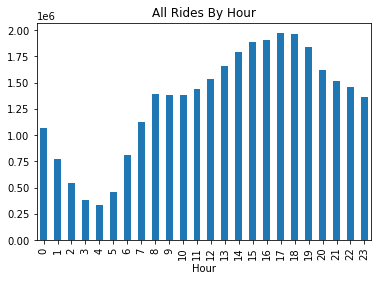

In [25]:
FHV.groupby('Hour')['DOW'].count().plot.bar()
plt.title('All Rides By Hour')

IndexError: index 0 is out of bounds for axis 0 with size 0

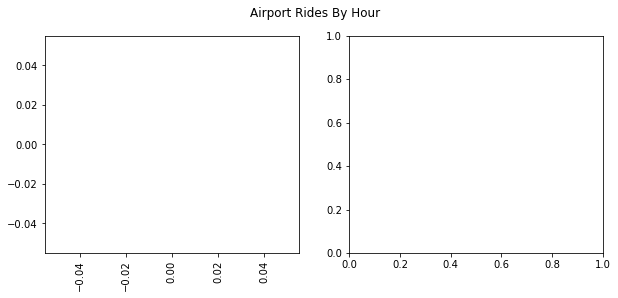

In [26]:
figure, ax = plt.subplots(1,2, figsize=(10,4))
plt.suptitle('Airport Rides By Hour')

FHV[(FHV['PULocationID'] == 1) | (FHV['DOLocationID'] == 1)].groupby('Hour')['DOW'].count().plot.bar(ax=ax[0])
FHV[(FHV['PULocationID'] == 132) | (FHV['DOLocationID'] == 132)].groupby('Hour')['DOW'].count().plot.bar(ax=ax[1])
ax[0].set_title('Newark')
ax[1].set_title('JFK')
plt.show()

In [ ]:
pd.get_dummies(FHV['PULocationID']).join(pd.get_dummies(FHV['DOLocationID']), lsuffix='PU', rsuffix='DO')

In [159]:
non_overnight_pickups = FHV[FHV['overnight']==0].PULocationID.value_counts().compute()

In [160]:
overnight_pickups = FHV[FHV['overnight']==1].PULocationID.value_counts().compute()

In [14]:
taxi_zones = gpd.read_file('./taxi_zones__7_/taxi_zones.shp')

In [89]:
ride_pct_change = ((FHV[FHV['overnight']==1].PULocationID.value_counts() \
                    - FHV[FHV['overnight']==0].PULocationID.value_counts())/\
                   FHV[FHV['overnight']==0].PULocationID.value_counts()).compute()

In [118]:
pd.Series(ride_pct_change.sort_values(ascending=False)).iloc[:20]

207   -0.529016
30    -0.805679
126   -0.848193
2     -0.861635
57    -0.862991
37    -0.867701
99    -0.868657
36    -0.870975
58    -0.871403
120   -0.871784
173   -0.872243
77    -0.873824
10    -0.875806
152   -0.876772
150   -0.876915
177   -0.877290
147   -0.879774
235   -0.879969
169   -0.880068
78    -0.880545
Name: PULocationID, dtype: float64

### Merging ACS and subway ridership data with FHV Data

In [10]:
# Import pct_change in subway ridership from May through August between 2019 and 2020

subway = pd.read_csv('MLC_data-main 3/data/ridership_by_taxizone/ridership_by_taxizone.csv')
subway = subway.drop(columns=['Unnamed: 0', '2019_entries', '2019_exits','2020_entries','2020_exits'])
subway['mean_pct_change'] = (subway['entries__pct_change'] + subway['exits_pct_change']) / 2

In [11]:
subway = subway.drop(columns=['entries__pct_change','exits_pct_change'])

In [12]:
# Import 2019 ACS variables for census_tracts and taxi

acs = pd.read_csv('MLC_data-main 3/data/census_zones/census_zones.csv')

In [13]:
# select relevant variables from ACS table

acs_var_names = {'healthcare':'SE_B17008_004','food_service':'SE_B17008_006','maintenance':'SE_B17008_007',\
                 'retail_sales':'SE_B17008_009', 'race_white':'SE_A03001_002', 'hh_median_income':'SE_A14006_001',\
                 'transit_commute':'SE_A09005_003','transit_12_5':'ACS19_5yr_B08132047','transit_60min+':'ACS19_5yr_B08134070'}

acs_var_names = {v: k for k, v in acs_var_names.items()}

acs_vars = [s.strip() for s in list(acs_var_names.keys())]

In [14]:
pd.DataFrame.from_dict(acs_var_names, orient='index')

,0
SE_B17008_004,healthcare
SE_B17008_006,food_service
SE_B17008_007,maintenance
SE_B17008_009,retail_sales
SE_A03001_002,race_white
SE_A14006_001,hh_median_income
SE_A09005_003,transit_commute
ACS19_5yr_B08132047,transit_12_5
ACS19_5yr_B08134070,transit_60min+


In [15]:
zone_acs1 = acs[['LocationID'] + acs_vars].groupby('LocationID').sum().drop(columns='SE_A14006_001')
zone_acs2 = acs[['LocationID','SE_A14006_001']].groupby('LocationID').mean()
zone_acs = zone_acs1.merge(zone_acs2, on='LocationID')

In [16]:
zone_acs.head()

,SE_B17008_004,SE_B17008_006,SE_B17008_007,SE_B17008_009,SE_A03001_002,SE_A09005_003,ACS19_5yr_B08132047,ACS19_5yr_B08134070,SE_A14006_001
LocationID,,,,,,,,,
2.0,0,0,0,0,0,0,0,0,NaN
3.0,794,531,697,1183,9220,5752,198,3922,78678.545455
4.0,643,512,394,1357,10121,7346,158,1255,48225.166667
5.0,361,290,258,1455,24498,2602,28,2322,91298.500000
6.0,334,409,182,565,11378,2640,36,1767,78611.000000


In [17]:
zone_acs.columns = [acs_var_names[x] for x in zone_acs.columns]

In [18]:
zone_acs['essential_workers'] = zone_acs.iloc[:,:4].sum(axis=1)

In [19]:
zone_acs = zone_acs.reset_index().drop(columns=['healthcare','food_service','maintenance','retail_sales'])

In [191]:
#essential_by_zone = pd.DataFrame(acs.groupby('LocationID')['SE_A17004_011'].mean())
#essential_by_zone = essential_by_zone.rename(columns={'SE_A17004_011':'essential_count'}).reset_index()
#essential_by_zone.head()

In [20]:
#merge FHV_test data with ACS and subway variables by Taxi Zone

FHV_merged = FHV.merge(zone_acs, left_on='PULocationID', right_on='LocationID', how='left').drop(columns='LocationID')\
    .merge(zone_acs, left_on='DOLocationID', right_on='LocationID', how='left').drop(columns='LocationID')

FHV_merged = FHV_merged.merge(subway, left_on='PULocationID', right_on='LocationID', how='left').drop(columns='LocationID')\
    .merge(subway, left_on='DOLocationID', right_on='LocationID', how='left').dropna()



In [21]:
FHV_merged.head()

,Company,PULocationID,DOLocationID,PUTime,DOTime,Duration,Hour,DOW,overnight,race_white_x,...,essential_workers_x,race_white_y,transit_commute_y,transit_12_5_y,transit_60min+_y,hh_median_income_y,essential_workers_y,mean_pct_change_x,LocationID,mean_pct_change_y
0,Uber,151,244,2020-05-06 00:01:26,2020-05-06 00:10:14,8.800000,0,2,0,21999.0,...,2610.0,28021.0,32802.0,515.0,9551.0,54295.666667,15013.0,-0.669249,244.0,-0.637957
1,Uber,74,32,2020-05-06 00:43:42,2020-05-06 00:59:27,15.750000,0,2,0,11740.0,...,7489.0,11322.0,10153.0,500.0,5815.0,40033.125000,4909.0,-0.633493,32.0,-0.540503
2,Via,35,177,2020-05-06 00:27:39,2020-05-06 00:35:04,7.416667,0,2,0,4790.0,...,6169.0,3427.0,11260.0,316.0,4129.0,43324.800000,4365.0,-0.583125,177.0,-0.575419
3,Via,188,61,2020-05-06 00:52:35,2020-05-06 00:58:13,5.633333,0,2,0,13762.0,...,9320.0,24225.0,39830.0,1379.0,11391.0,51373.629630,12958.0,-0.582923,61.0,-0.626409
4,Uber,225,35,2020-05-06 00:19:59,2020-05-06 00:28:43,8.733333,0,2,0,13131.0,...,8365.0,4790.0,11784.0,506.0,5603.0,27391.666667,6169.0,-0.610063,35.0,-0.583125


In [22]:
FHV_merged = FHV_merged.rename(columns={'essential_count_x':'PU_essential_count','essential_count_y':'DO_essential_count',\
                          'mean_pct_change_x':'PU_subway_decrease','mean_pct_change_y':'DO_subway_decrease'}).drop(columns='LocationID')



### Exploratory Data Analysis


In [23]:
def green_over_one(val):
    color = '' if val < 1 else 'honeydew'
    return 'background-color: %s' % color

In [24]:
(FHV_merged.iloc[:,7:].groupby('overnight').mean() / FHV_merged.iloc[:,7:].mean())\
    .drop(columns=['overnight','DOW']).transpose().rename(columns={0:'no', 1:'yes'}).style.applymap(green_over_one)

overnight,no,yes
DO_subway_decrease,1.001739,0.979534
PU_subway_decrease,1.001563,0.981608
essential_workers_x,0.993465,1.076906
essential_workers_y,0.992876,1.083840
hh_median_income_x,1.008868,0.895634
hh_median_income_y,1.009659,0.886333
race_white_x,1.005129,0.939644
race_white_y,1.004962,0.941601
transit_12_5_x,0.988893,1.130715
transit_12_5_y,0.988699,1.132999


In [27]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: honeydew' if v else '' for v in is_max]

In [28]:
overnight_means = FHV_merged.iloc[:,7:].groupby('overnight').mean().drop(columns='DOW').rename(columns={0:'no', 1:'yes'}).style.apply(highlight_max)
overnight_means

,race_white_x,transit_commute_x,transit_12_5_x,transit_60min+_x,hh_median_income_x,essential_workers_x,race_white_y,transit_commute_y,transit_12_5_y,transit_60min+_y,hh_median_income_y,essential_workers_y,PU_subway_decrease,DO_subway_decrease
overnight,,,,,,,,,,,,,,
0,17369.079957,14395.191822,396.140011,4495.116887,75056.597929,6033.633454,17368.741893,14338.894087,394.178728,4487.964693,75444.121915,6012.934114,-0.622445,-0.622435
1,16237.476170,15155.413177,452.952665,4930.146954,66632.324298,6540.398088,16273.667607,15088.833971,451.708951,4955.193199,66228.963902,6563.818107,-0.610043,-0.608638


In [718]:
FHV_merged[FHV_merged['overnight']==1].iloc[:,9:].mean()

pct_white_x              16760.857125
pct_transit_commute_x    15034.838875
transit_12_5_x             432.712749
transit_60min+_x          4760.663858
hh_median_income_x       70871.312334
essential_workers_x       6308.321230
pct_white_y              16868.007536
pct_transit_commute_y    14856.445071
transit_12_5_y             425.826427
transit_60min+_y          4760.834645
hh_median_income_y       70702.399080
essential_workers_y       6293.211836
PU_subway_change            -0.619228
DO_subway_change            -0.615850
dtype: float64

### Classification Tests

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [30]:
FHV_merged = FHV_merged.join(pd.get_dummies(FHV_merged['DOW'])).drop(columns=['DOW','Hour'])

In [31]:
FHV_merged = FHV_merged.join(pd.get_dummies(FHV_merged['Company'])).drop(columns='Company')

In [587]:
FHV_merged.drop(columns=['PUTime','DOTime','overnight'])

,PULocationID,DOLocationID,Duration,pct_white_x,pct_transit_commute_x,transit_12_5_x,transit_60min+_x,hh_median_income_x,essential_workers_x,pct_white_y,...,0,1,2,3,4,5,6,Lyft,Uber,Via
0,260,129,10.700000,18985.0,15002.0,385.0,2996.0,64765.833333,6166.0,46445.0,...,0,0,1,0,0,0,0,0,1,0
1,146,74,18.816667,2927.0,3140.0,68.0,489.0,73450.000000,1179.0,11740.0,...,0,0,1,0,0,0,0,0,1,0
2,74,42,4.200000,11740.0,17396.0,311.0,2752.0,33484.090909,7489.0,13339.0,...,0,0,1,0,0,0,0,0,1,0
3,42,235,11.933333,13339.0,28784.0,848.0,4921.0,52185.187500,9446.0,5382.0,...,0,0,1,0,0,0,0,0,1,0
4,37,17,8.200000,25825.0,25923.0,814.0,7703.0,59154.333333,10271.0,35888.0,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1791813,75,237,7.900000,23479.0,16858.0,367.0,2400.0,50623.818182,5960.0,15803.0,...,1,0,0,0,0,0,0,0,1,0
1791814,236,113,15.166667,32246.0,11968.0,27.0,599.0,177116.125000,2915.0,16269.0,...,1,0,0,0,0,0,0,0,1,0
1791815,69,137,28.183333,8405.0,17493.0,906.0,6858.0,33030.307692,10351.0,15913.0,...,1,0,0,0,0,0,0,0,1,0
1791816,181,140,21.450000,52345.0,28187.0,179.0,4473.0,142617.000000,3852.0,22657.0,...,1,0,0,0,0,0,0,0,1,0


In [32]:
X = FHV_merged.drop(columns=['PUTime','DOTime','overnight'])
y = FHV_merged['overnight']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=9,test_size=0.4)

In [589]:
lm = LogisticRegression()
lm.fit(X_train,y_train)
lm.score(X_train,y_train)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.5605901278223819

In [33]:
dt=DecisionTreeClassifier()
dt.fit(X_train,y_train)
print('IS R2:',dt.score(X_train,y_train))
print('OS R2:',dt.score(X_test,y_test))

IS R2: 0.9795896916187908
OS R2: 0.8749423355396914


In [623]:
rf = RandomForestClassifier(n_estimators=30)
rf.fit(X_train,y_train)
print('IS R2:',rf.score(X_train,y_train))
print('OS R2:',rf.score(X_test,y_test))

IS R2: 0.9867586446769658
OS R2: 0.6318039292751345


In [34]:
param_grid = {'max_depth':range(2,30)}
rf = RandomForestClassifier(n_estimators=30)
gs = GridSearchCV(rf,param_grid=param_grid,scoring='accuracy')
rs = gs.fit(X_train,y_train)
pred=rs.predict(X_test)
print(rs.best_params_)
print(accuracy_score(np.array(y_test),pred))

KeyboardInterrupt: 

In [640]:
pred=rs.predict(X_train)

In [641]:
correct=1.0*(pred==y_train).sum()/len(y_train)
correct

0.6463163386568506

In [648]:
accuracy_score(y_train,pred)

0.6463163386568506

In [633]:
print(roc_auc_score(np.array(y_test),pred))

0.6856680241632485


In [394]:
FHV_test.groupby(['PULocationID','DOLocationID']).agg({'Company':'count', 'overnight':'sum'}).sort_values('overnight',ascending=False)

Company  overnight
PULocationID DOLocationID                    
76           76               6587       3377
39           39               4784       2411
61           61               2827       1675
215          130              3004       1663
205          130              2762       1463
...                            ...        ...
87           52                  1          0
218          133                 3          0
             126                 1          0
87           84                  1          0
             34                  7          0

[44057 rows x 2 columns]